### This notebook shows examples of how to use the cyclops.processor API on GEMINI.

## Get all patient encounters including ER data, with diagnoses from St. Michael's hospital from March 1 2020 to March 15 2020, with vitals and labs and interventions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from cyclops.processor import featurize
from cyclops.processors.aggregate import Aggregator
from cyclops.processors.column_names import AGE, DIAGNOSIS_CODE, ENCOUNTER_ID, SEX, HOSPITAL_ID, ADMIT_TIMESTAMP
from cyclops.processors.constants import SMH
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.processors.impute import Imputer
from cyclops.processors.utils import gather_columns
from cyclops.query import gemini

# patients = gemini.patients(
#     hospitals=[SMH], from_date="2020-03-01", to_date="2020-03-15", include_er_data=True
# )
# patients_diagnoses = gemini.diagnoses(patients=patients)
# patients_vitals = gemini.events(patients=patients, category="vitals")
# patients_labs = gemini.events(patients=patients, category="lab")
# patients_interventions = gemini.events(patients=patients, category="intervention")

# diagnoses_data = patients_diagnoses.run()
# vitals_data = patients_vitals.run()
# labs_data = patients_labs.run()
# interventions_data = patients_interventions.run()

# print(f"{len(diagnoses_data)} diagnoses rows extracted!")
# print(f"{len(vitals_data)} vitals rows extracted!")
# print(f"{len(labs_data)} labs rows extracted!")
# print(f"{len(interventions_data)} interventions rows extracted!")

# patients_diagnoses.save(".", "diagnoses")
# patients_vitals.save(".", "vitals")
# patients_labs.save(".", "lab")
# patients_interventions.save(".", "intervention")

2022-04-26 17:57:44,258 INFO cyclops.processors.utils - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:44,264 INFO cyclops.utils.profile - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:44,268 INFO cyclops.processors.aggregate - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:44,273 INFO cyclops.processors.diagnoses - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:44,362 INFO cyclops.processors.events - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:45,765 INFO cyclops.processors.impute - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:45,793 INFO cyclops.processors.feature_handler - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:46,075 INFO cyclops.config  - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-26 17:57:46,234 INFO cyclops.query.utils - Log f

## Process queried data into features. (Static + Temporal).

In [2]:
diagnoses_data = pd.read_parquet("diagnoses.gzip")
vitals_data = pd.read_parquet("vitals.gzip")
labs_data = pd.read_parquet("lab.gzip")
interventions_data = pd.read_parquet("intervention.gzip")

static_diagnoses_data = gather_columns(
    diagnoses_data, [ENCOUNTER_ID, AGE, SEX, DIAGNOSIS_CODE, HOSPITAL_ID, ADMIT_TIMESTAMP]
)
feature_handler = featurize(
    static_data=[static_diagnoses_data],
    temporal_data=[labs_data, vitals_data],
    aggregator=Aggregator(bucket_size=1, window=24),
    static_imputer=Imputer(strategy="median"),
    temporal_imputer=Imputer(strategy="median"),
    reference_cols=[HOSPITAL_ID, ADMIT_TIMESTAMP]
)

2022-04-26 17:57:47,311 INFO cyclops.processors.utils - Processing raw diagnosis codes...
2022-04-26 17:57:47,314 INFO cyclops.processors.utils - # samples: 1068, # encounters: 150
2022-04-26 17:57:47,391 INFO cyclops.processors.utils - Grouping ICD codes to trajectories...
2022-04-26 17:57:47,408 INFO cyclops.processors.utils - # samples: 1068, # encounters: 150
2022-04-26 17:57:47,410 INFO cyclops.processors.diagnoses - # diagnosis features: 19, # encounters: 150
2022-04-26 17:57:47,555 INFO cyclops.utils.profile - Finished executing function group_diagnosis_codes_to_trajectories in 0.243959 s
2022-04-26 17:57:47,600 INFO cyclops.processors.utils - Gathering static features...
2022-04-26 17:57:47,612 INFO cyclops.processors.utils - # samples: 1068, # encounters: 150
2022-04-26 17:57:47,614 INFO cyclops.processors.utils - # columns: 5, # encounters: 150
2022-04-26 17:57:47,938 INFO cyclops.utils.profile - Finished executing function gather_static_features in 0.338243 s
2022-04-26 17:5

## Inspect feature handler, plot example temporal features and save them.

{'static': ['age'], 'temporal': ['sodium', 'urine sodium', 'urine specific gravity', 'bicarbonate', 'blood urea nitrogen', 'vitamin b12', 'white blood cell count', 'high sensitivity troponin', 'vitamin d', 'hba1c', 'lymphocyte', 'neutrophils', 'albumin', 'aptt', 'bilirubin', 'calcium', 'calcium, ionized', 'creatinine', 'esr', 'serum alcohol', 'ferritin', 'fibrinogen', 'glucose point of care', 'glucose random', 'hematocrit', 'hemoglobin', 'crp', 'inr', 'ketone', 'lactate arterial', 'lactate venous', 'mean cell volume', 'arterial paco2', 'venous pco2', 'arterial ph', 'venous ph', 'platelet count', 'arterial pao2', 'potassium', 'pt', 'diastolic bp', 'oxygen saturation', 'oxygen flow rate', 'heart rate', 'respiratory rate', 'systolic bp', 'temperature', 'weight']}
{'static': ['F01_F99', 'K00_K95', 'R00_R99', 'D50_D89', 'S00_T88', 'V00_Y99', 'H60_H95', 'M00_M99', 'A00_B99', 'G00_G99', 'Z00_Z99', 'C00_D49', 'I00_I99', 'J00_J99', 'N00_N99', 'L00_L99', 'E00_E89', 'H00_H59', 'Q00_Q99', 'sex'], 

2022-04-26 17:58:26,421 INFO cyclops.processors.feature_handler - Saving static features to ./test_features_static.gzip
2022-04-26 17:58:26,442 INFO cyclops.processors.feature_handler - Saving temporal features to ./test_features_temporal.gzip


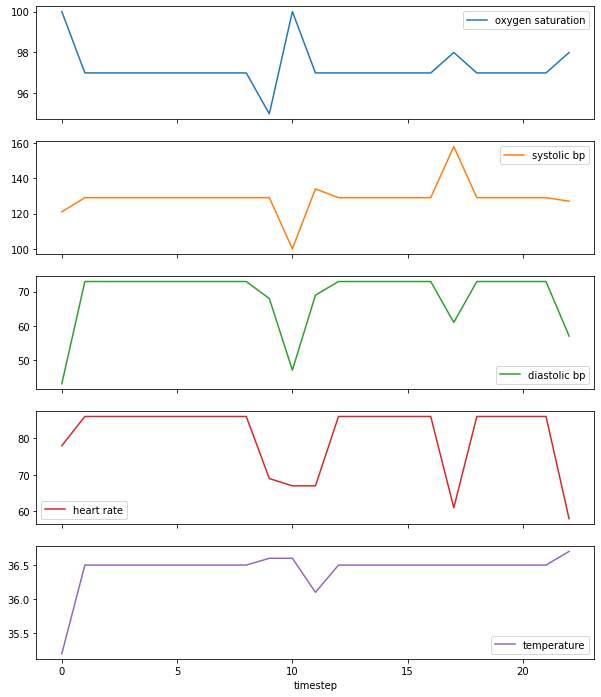

In [3]:
print(feature_handler.get_numerical_feature_names())
print(feature_handler.get_categorical_feature_names())

plot_features = [
    "oxygen saturation",
    "systolic bp",
    "diastolic bp",
    "heart rate",
    "temperature",
]
feature_handler.features["temporal"].index
feature_handler.features["temporal"].loc[11942185]
feature_handler.features["temporal"].loc[11942185][plot_features].plot(
    subplots=True, figsize=(10, 12)
)
feature_handler.save(".", "test_features")

## Create new FeatureHandler and load features from file.

In [4]:
# feature_handler = FeatureHandler()
# feature_handler.load(".", "test_features")